# Notebook to plot REMUS 600 data from Pioneer Array

In [1]:
#!pip install git+https://github.com/seagrinch/ooilab.git
import ooilab
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.dates as dates

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

Go to https://ooinet.oceanobservatories.org/data_access/#CP05MOAS-A6264-03-CTDAVN000 and request data download  
--> will recieve email with a link for direct download or opendap link. The latter allows you to load data directly into python (see below)


Ideally we want to use the ooilab toolbox (https://github.com/seagrinch/ooilab, https://datalab.marine.rutgers.edu/2020/11/my-ooilab-python-toolbox/)where we don't need to request data through the data portal first to get the link. However, I get an error using it at the moment.

In [2]:
url1 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sryan@whoi.edu/20210322T140441502Z-CP05MOAS-A6263-03-CTDAVN000-recovered_host-ctdav_auv_data/catalog.html'
# url2 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sryan@whoi.edu/20210323T013051722Z-CP05MOAS-A6264-03-CTDAVN000-recovered_host-ctdav_auv_data/catalog.html'
flist = ooilab.get_filelist(url1)
flist

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sryan@whoi.edu/20210322T140441502Z-CP05MOAS-A6263-03-CTDAVN000-recovered_host-ctdav_auv_data/deployment0002_CP05MOAS-A6263-03-CTDAVN000-recovered_host-ctdav_auv_data_20160529T123527.599000-20160531T140342.533000.nc#fillmismatch',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sryan@whoi.edu/20210322T140441502Z-CP05MOAS-A6263-03-CTDAVN000-recovered_host-ctdav_auv_data/deployment0003_CP05MOAS-A6263-03-CTDAVN000-recovered_host-ctdav_auv_data_20161012T000040.533000-20161013T034146.349000.nc#fillmismatch',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sryan@whoi.edu/20210322T140441502Z-CP05MOAS-A6263-03-CTDAVN000-recovered_host-ctdav_auv_data/deployment0004_CP05MOAS-A6263-03-CTDAVN000-recovered_host-ctdav_auv_data_20170610T123823.733000-20170611T003558.016000.nc#fillmismatch',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/sryan@whoi.edu/20210322T140441502Z-CP05MOAS-A6263-03-CTDAVN000-recovered_h

In [3]:
# open all files available and load into xarray
ds = xr.open_mfdataset(flist).swap_dims({'obs': 'time'}).sortby('time')
ds

<xarray.Dataset>
Dimensions:                               (time: 1629621)
Coordinates:
    obs                                   (time) int64 0 1 2 ... 177185 177186
  * time                                  (time) datetime64[ns] 2016-05-29T12:35:27.599000064 ... 2019-10-02T22:02:23.083000320
Data variables:
    speed_of_sound_qc_results             (time) float32 dask.array<chunksize=(91115,), meta=np.ndarray>
    temperature_qc_executed               (time) float32 dask.array<chunksize=(91115,), meta=np.ndarray>
    driver_timestamp                      (time) datetime64[ns] dask.array<chunksize=(91115,), meta=np.ndarray>
    id                                    (time) |S64 dask.array<chunksize=(91115,), meta=np.ndarray>
    temperature                           (time) float32 dask.array<chunksize=(91115,), meta=np.ndarray>
    dissolved_oxygen_qc_executed          (time) float32 dask.array<chunksize=(91115,), meta=np.ndarray>
    speed_of_sound                        (time) float3

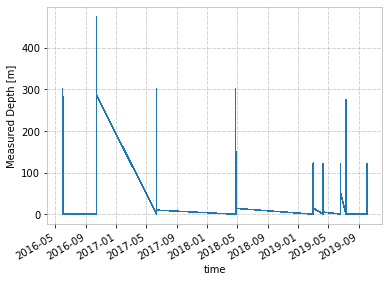

In [4]:
# check data
ds.m_depth.plot()

We can see that there are multiple deployments. If we zoom in we see that one deployment consists of multiple profiles.

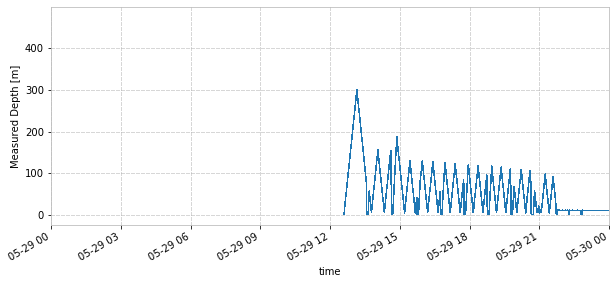

In [5]:
# just limit axis to time period (based on eye)
plt.figure(figsize=(10,4))
ds.m_depth.plot(xlim=('2016-05-29','2016-05-30'))

In [6]:
# select data for only one mission to plot
ds = ds.sel(time=slice('2016-05-29','2016-05-30'))

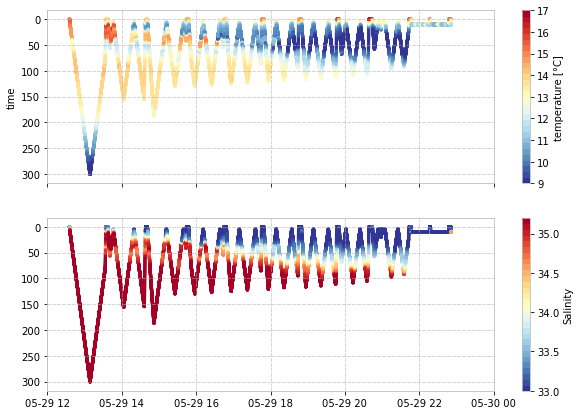

In [7]:
# plot profiles (up- and downcast) as scatter plot

fig,ax = plt.subplots(figsize=(10,7),nrows=2,sharex=True,sharey=True)
c = ax[0].scatter(ds.time.values,ds.m_depth,s=5,
                    c=ds.temperature,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=9,vmax=17)
c2 = ax[1].scatter(ds.time.values,ds.m_depth,s=5,
                    c=ds.salinity,
                    cmap = plt.get_cmap('RdYlBu_r',30),vmin=33,vmax=35.2)
ax[0].set_xlim('2016-05-29T12:00:00','2016-05-30')
ax[0].invert_yaxis()
ax[0].set_ylabel('depth [m]')
ax[0].set_ylabel('time')

plt.colorbar(c,ax=ax[0],label='temperature [\N{DEGREE SIGN}C]')
plt.colorbar(c2,ax=ax[1],label='Salinity')

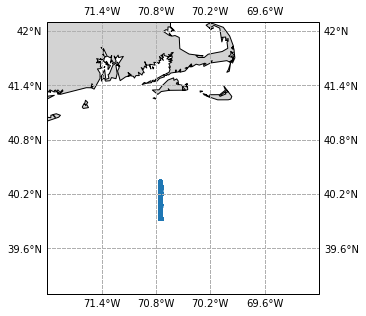

In [16]:
# plot map of positions

# define projection
proj = ccrs.PlateCarree()

fig,ax = plt.subplots(figsize=(6,5),subplot_kw = dict(projection=proj))

# formatting
ax.set_extent([-72,-69,39.1,42.1])
# ax.coastlines(resolution='50m',color='gray')
gl = ax.gridlines(crs=proj,draw_labels=True)
gl.yformatter = LATITUDE_FORMATTER
gl.xformatter = LONGITUDE_FORMATTER
ax.add_feature(cartopy.feature.GSHHSFeature(), facecolor='lightgray',edgecolor='k')

# add lat,lon from section
ax.scatter(ds.auv_longitude,ds.auv_latitude,marker='*',transform=proj)

# # add coastlines from GSHHS
# shpfile = cartopy.io.shapereader.gshhs('h')
# shp = cartopy.io.shapereader.Reader(shpfile)
# ax.add_geometries(
#     shp.geometries(), ccrs.PlateCarree(), edgecolor='k', facecolor='lightgray')

In future it would be nice to add bathymetry to the map as well as higher resolution coastline (https://ocefpaf.github.io/python4oceanographers/blog/2015/06/22/osm/)

# Possible future steps  

- plot scatter plots for all different deployments
- plot individual profiles (need to separate profiles)
- see https://github.com/sryan288/ohw20-proj-ooi-profiles-section/blob/master/01_OOI_Profiles_Svenja.ipynb for some examples of what to do with profiling data.